In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from wordcloud import WordCloud
from collections import Counter
import nltk
import spacy
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D, Input, SimpleRNN
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')
np.random.seed(42)
nltk.download('punkt_tab')
nltk.download("stopwords")
!python -m spacy download en_core_web_sm

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 76.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
training = pd.read_csv('twitter_training.csv')
testing = pd.read_csv('twitter_test.csv')

In [3]:
training.head()

2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...

In [4]:
testing.head()

3364   Facebook Irrelevant  \
0   352     Amazon    Neutral   
1  8312  Microsoft   Negative   
2  4371      CS-GO   Negative   
3  4433     Google    Neutral   
4  6273       FIFA   Negative   

  I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣  
0  BBC News - Amazon boss Jeff Bezos rejects clai...                                                                                                                                                                                                  
1  @Microsoft Why do I pay for WORD when it funct...                                                                                                                                                                                                  
2  CSGO matchmaking is so full of closet hacking,...                                                                                                                                                                                                  
3  Now the President is slapping Americans in the...                                                                                                                                                                                                  
4  Hi @EAHelp I’ve had Madeleine McCann in my cel...

In [5]:
training.columns = ["id", "organization", "label", "tweet"]
testing.columns = ["id", "organization", "label", "tweet"]

In [6]:
training.head()

id organization     label  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                               tweet  
0  I am coming to the borders and I will kill you...  
1  im getting on borderlands and i will kill you ...  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands 2 and i will murder ...  
4  im getting into borderlands and i can murder y...

In [7]:
testing.head()

id organization     label  \
0   352       Amazon   Neutral   
1  8312    Microsoft  Negative   
2  4371        CS-GO  Negative   
3  4433       Google   Neutral   
4  6273         FIFA  Negative   

                                               tweet  
0  BBC News - Amazon boss Jeff Bezos rejects clai...  
1  @Microsoft Why do I pay for WORD when it funct...  
2  CSGO matchmaking is so full of closet hacking,...  
3  Now the President is slapping Americans in the...  
4  Hi @EAHelp I’ve had Madeleine McCann in my cel...

In [8]:
data = pd.concat([training, testing], ignore_index= True)
data.head()

id organization     label  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                               tweet  
0  I am coming to the borders and I will kill you...  
1  im getting on borderlands and i will kill you ...  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands 2 and i will murder ...  
4  im getting into borderlands and i can murder y...

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75680 entries, 0 to 75679
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            75680 non-null  int64 
 1   organization  75680 non-null  object
 2   label         75680 non-null  object
 3   tweet         74994 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [10]:
data = data.drop(columns = ["id", "organization"])
data.head(10)

label                                              tweet
0  Positive  I am coming to the borders and I will kill you...
1  Positive  im getting on borderlands and i will kill you ...
2  Positive  im coming on borderlands and i will murder you...
3  Positive  im getting on borderlands 2 and i will murder ...
4  Positive  im getting into borderlands and i can murder y...
5  Positive  So I spent a few hours making something for fu...
6  Positive  So I spent a couple of hours doing something f...
7  Positive  So I spent a few hours doing something for fun...
8  Positive  So I spent a few hours making something for fu...
9  Positive  2010 So I spent a few hours making something f...

In [11]:
data["tweet"] = data["tweet"].str.lower()
data.head(10)

label                                              tweet
0  Positive  i am coming to the borders and i will kill you...
1  Positive  im getting on borderlands and i will kill you ...
2  Positive  im coming on borderlands and i will murder you...
3  Positive  im getting on borderlands 2 and i will murder ...
4  Positive  im getting into borderlands and i can murder y...
5  Positive  so i spent a few hours making something for fu...
6  Positive  so i spent a couple of hours doing something f...
7  Positive  so i spent a few hours doing something for fun...
8  Positive  so i spent a few hours making something for fu...
9  Positive  2010 so i spent a few hours making something f...

In [12]:
data.isnull().sum()

label      0
tweet    686
dtype: int64

In [13]:
data["tweet"].isnull().sum() / data.shape[0]

np.float64(0.009064482029598309)

In [14]:
data = data.dropna().reset_index(drop = True)
data.isnull().sum()

label    0
tweet    0
dtype: int64

In [15]:
data.duplicated().sum()

np.int64(5031)

In [16]:
data = data.drop_duplicates(keep = "first").reset_index(drop = True)
data.duplicated().sum()

np.int64(0)

In [17]:
data["No_of_characters"] = data["tweet"].apply(len)
data["No_of_words"] = data.apply(lambda row: nltk.word_tokenize(row["tweet"]), axis = 1).apply(len)
data["No_of_sentences"] = data.apply(lambda row: nltk.sent_tokenize(row["tweet"]), axis = 1).apply(len)
data.head()

label                                              tweet  \
0  Positive  i am coming to the borders and i will kill you...   
1  Positive  im getting on borderlands and i will kill you ...   
2  Positive  im coming on borderlands and i will murder you...   
3  Positive  im getting on borderlands 2 and i will murder ...   
4  Positive  im getting into borderlands and i can murder y...   

   No_of_characters  No_of_words  No_of_sentences  
0                51           13                1  
1                50           11                1  
2                51           11                1  
3                57           13                1  
4                53           11                1

In [18]:
data_with_one_word = data[data["No_of_words"] == 1]
print(len(data_with_one_word))
data_with_one_word.head(10)

433


label  tweet  No_of_characters  No_of_words  No_of_sentences
10     Positive    was                 3            1                1
49      Neutral    all                 3            1                1
181    Positive    why                 3            1                1
191    Negative      i                 1            1                1
372  Irrelevant     is                 2            1                1
414  Irrelevant  there                 5            1                1
438    Positive    one                 3            1                1
449    Positive    can                 3            1                1
466    Positive     of                 2            1                1
496    Positive     it                 2            1                1

In [19]:
data_with_two_words = data[data["No_of_words"] == 2]
print(len(data_with_two_words))
data_with_two_words.head(10)

983


label             tweet  No_of_characters  No_of_words  \
57    Neutral              .. [                 4            2   
58    Neutral             .. 45                 5            2   
59    Neutral           .. what                 7            2   
239   Neutral     slutsky......                13            2   
532   Neutral      trying out                  12            2   
534   Neutral         trying it                 9            2   
536   Neutral           you out                 7            2   
718  Positive  series completed                16            2   
951  Positive         the sweat                 9            2   
952  Positive         for sweet                 9            2   

     No_of_sentences  
57                 1  
58                 1  
59                 1  
239                1  
532                1  
534                1  
536                1  
718                1  
951                1  
952                1

In [20]:
data_with_three_words = data[data["No_of_words"] == 3]
print(len(data_with_three_words))
data_with_three_words.head(10)

1364


label               tweet  No_of_characters  No_of_words  \
56     Neutral             . . [                   8            3   
78    Positive  fuck yessssssss .                 18            3   
79    Positive      fick yessssss.                14            3   
80    Positive    fuck yessssssss.                16            3   
83    Positive           fuck you.                 9            3   
336   Positive               <unk>                 5            3   
511   Negative          holy week!                10            3   
535    Neutral       trying it out                13            3   
931   Negative       again and wtf                13            3   
1003   Neutral     amazing photos.                15            3   

      No_of_sentences  
56                  3  
78                  1  
79                  1  
80                  1  
83                  1  
336                 1  
511                 1  
535                 1  
931                 1  
1003                1

In [21]:
data = data[data["No_of_words"] > 2]
data.shape

(68543, 5)

In [22]:
data = data.reset_index(drop = True)

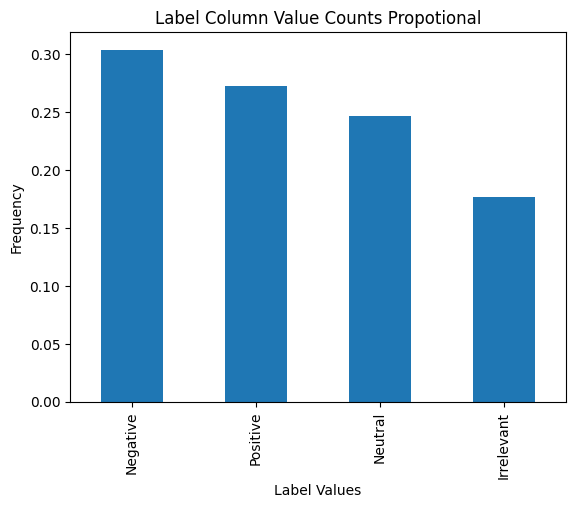

In [23]:
data["label"].value_counts(normalize = True).plot(kind = "bar", title = "Label Column Value Counts Propotional")
plt.xlabel("Label Values")
plt.ylabel("Frequency")
plt.show();

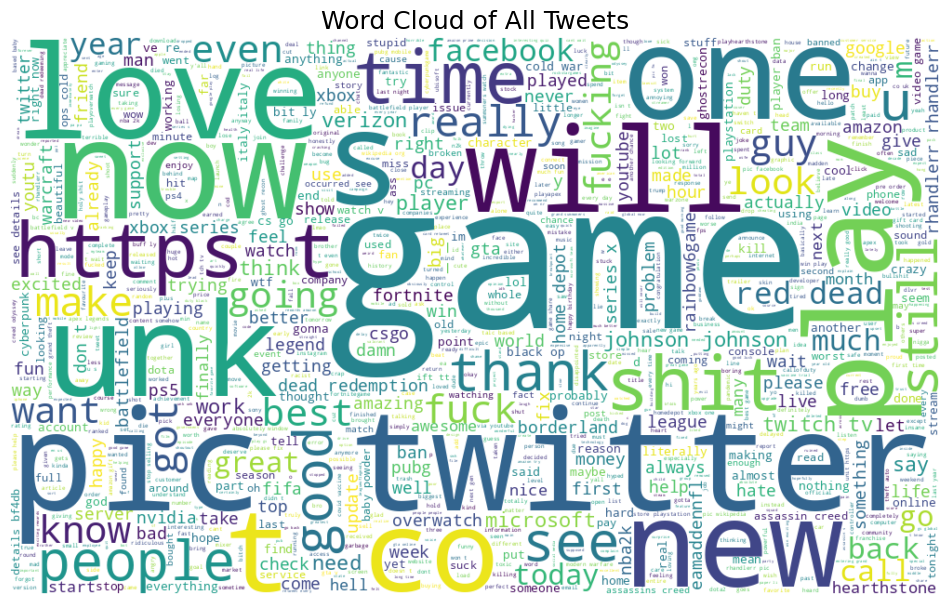

In [24]:
all_text = " ".join(data["tweet"].astype(str))

word_cloud = WordCloud(
    width = 1000,
    height = 600,
    background_color = "white",
    stopwords = None,
    max_words = 1000,
    colormap = "viridis",
).generate(all_text)

plt.figure(figsize = (12, 8))
plt.imshow(word_cloud, interpolation = "bilinear")
plt.axis("off")
plt.title('Word Cloud of All Tweets', fontsize=18)
plt.show();

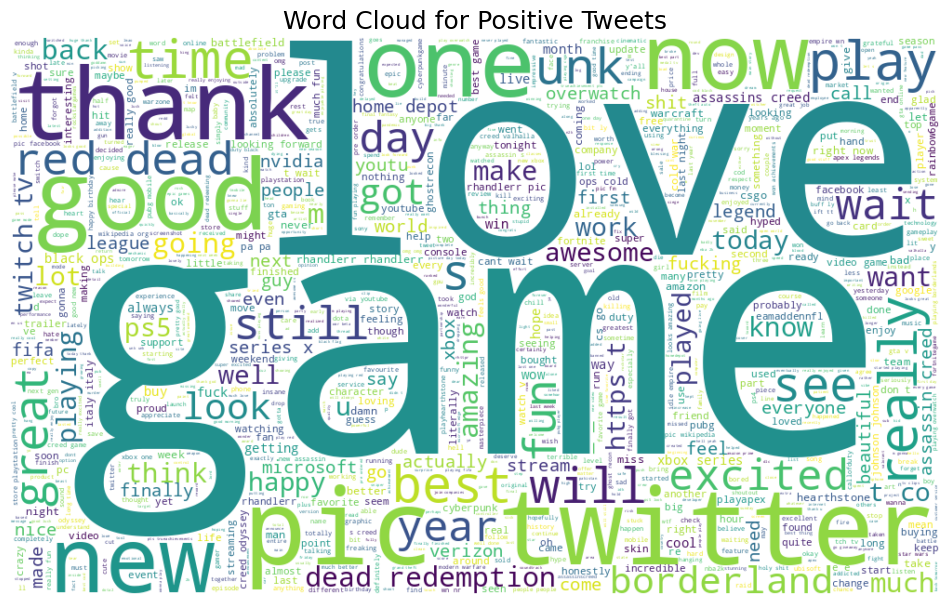

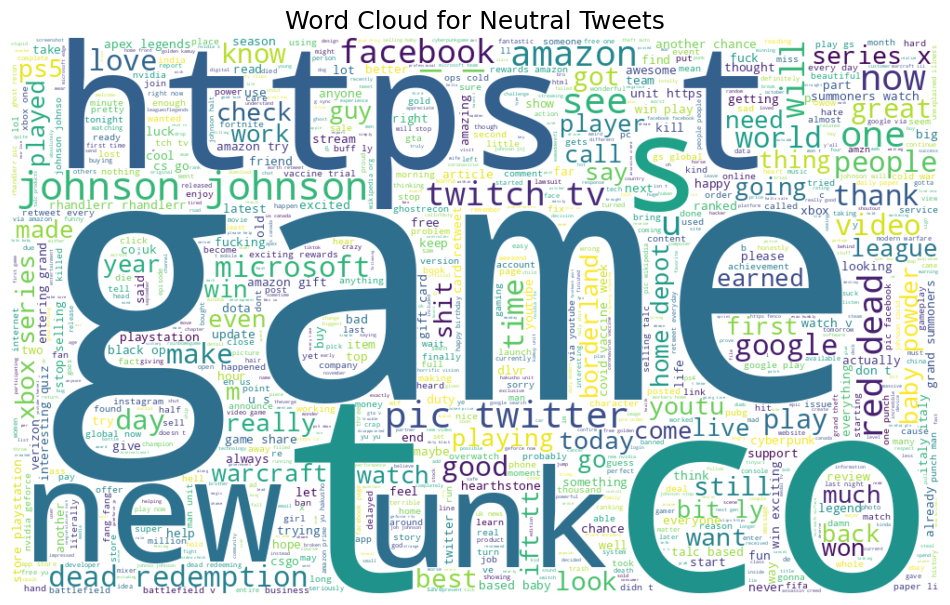

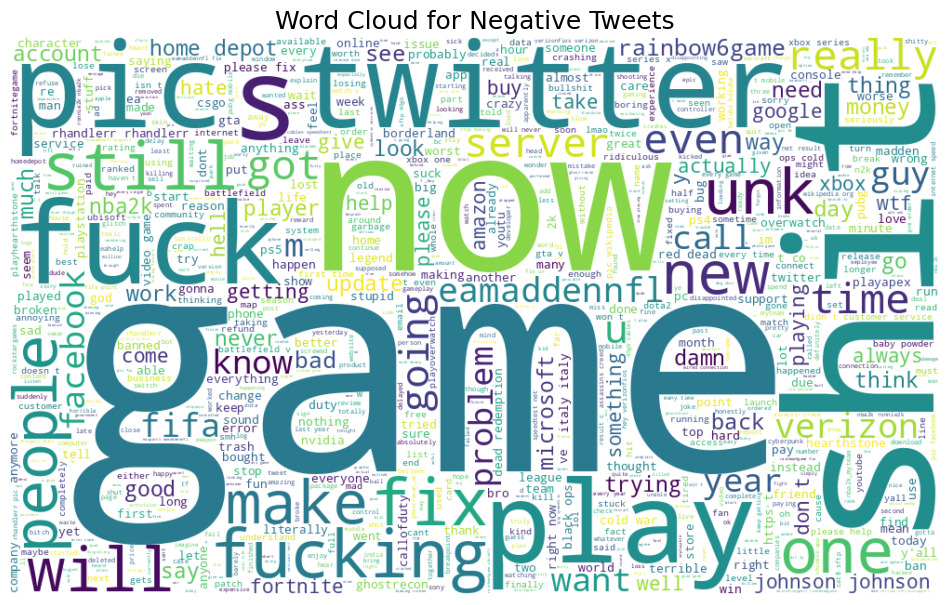

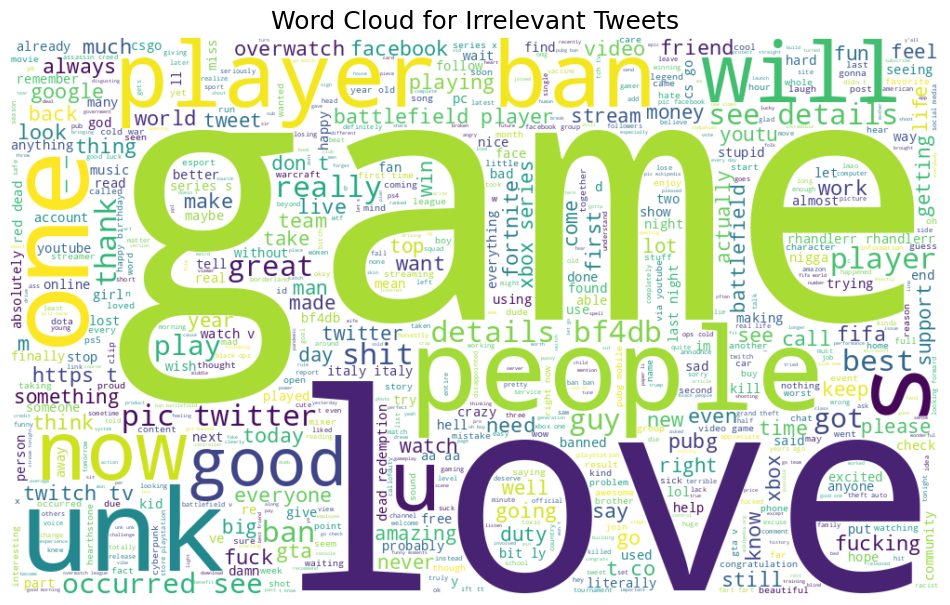

In [25]:
labels = data["label"].unique()

for label in labels:

  subset = data[data["label"] == label]
  text = " ".join(subset["tweet"].astype(str))
  word_cloud = WordCloud(
      width = 1000,
      height = 600,
      background_color= "white",
      colormap = "viridis",
      stopwords = None,
      max_words = 1000
  ).generate(text)

  plt.figure(figsize = (12, 8))
  plt.imshow(word_cloud, interpolation = "bilinear")
  plt.axis('off')
  plt.title(f'Word Cloud for {label} Tweets', fontsize=18)
  plt.show();

In [26]:
stop_words = set(stopwords.words("english"))

negation = {"not", "no", "nor", "never"}

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove <unk> or unk tokens
    text = re.sub(r'(<unk>|unk)', '', text, flags=re.IGNORECASE)

    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra white space from text
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Limit repetitive characters (e.g., "yessss" -> "yess")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Use spaCy for tokenization and lemmatization
    doc = nlp(text)

    # Lemmatize and remove stopwords (except negations)
    words = [
        token.lemma_
        for token in doc
        if (token.text not in stop_words or token.text in negation) and token.is_alpha
    ]

    return " ".join(words)


In [27]:
data["cleaned_tweet"] = data["tweet"].apply(preprocess_text)
data.head(20)

label                                              tweet  \
0   Positive  i am coming to the borders and i will kill you...   
1   Positive  im getting on borderlands and i will kill you ...   
2   Positive  im coming on borderlands and i will murder you...   
3   Positive  im getting on borderlands 2 and i will murder ...   
4   Positive  im getting into borderlands and i can murder y...   
5   Positive  so i spent a few hours making something for fu...   
6   Positive  so i spent a couple of hours doing something f...   
7   Positive  so i spent a few hours doing something for fun...   
8   Positive  so i spent a few hours making something for fu...   
9   Positive  2010 so i spent a few hours making something f...   
10   Neutral  rock-hard la varlope, rare & powerful, handsom...   
11   Neutral  rock-hard la varlope, rare & powerful, handsom...   
12   Neutral  rock-hard la varlope, rare & powerful, handsom...   
13   Neutral  rock-hard la vita, rare but powerful, handsome...   
14   Neutral  live rock - hard music la la varlope, rare & t...   
15   Neutral  i-hard like me, rare london de, handsome 2011,...   
16  Positive  that was the first borderlands session in a lo...   
17  Positive  this was the first borderlands session in a lo...   
18  Positive  that was the first borderlands session in a lo...   
19  Positive  that i was the first real borderlands session ...   

    No_of_characters  No_of_words  No_of_sentences  \
0                 51           13                1   
1                 50           11                1   
2                 51           11                1   
3                 57           13                1   
4                 53           11                1   
5                286           62                8   
6                293           63                2   
7                139           32                1   
8                283           61                8   
9                288           62                8   
10                94           17                1   
11                94           19                1   
12                93           19                1   
13                91           17                1   
14               136           32                2   
15                82           17                1   
16               142           26                2   
17               144           26                2   
18               146           26                2   
19               163           31                2   

                                        cleaned_tweet  
0                                    come border kill  
1                                 get borderland kill  
2                              come borderland murder  
3                               get borderland murder  
4                               get borderland murder  
5   spend hour make something fun not know huge bo...  
6   spend couple hour something fun not know huge ...  
7   spend hour something fun not know huge borderl...  
8   spend hour make something fun not know huge rh...  
9   spend hour make something fun not know huge rh...  
10  rockhard la varlope rare powerful handsome jac...  
11  rockhard la varlope rare powerful handsome jac...  
12  rockhard la varlope rare powerful handsome jac...  
13  rockhard la vita rare powerful handsome jackpo...  
14  live rock hard music la la varlope rare powerf...  
15  ihard like rare london de handsome borderland ...  
16  first borderland session long time actually re...  
17  first borderland session long time actually re...  
18  first borderland session long time actually en...  
19  first real borderland session nice long wait t...

In [28]:
data.isnull().sum()

label               0
tweet               0
No_of_characters    0
No_of_words         0
No_of_sentences     0
cleaned_tweet       0
dtype: int64

In [29]:
data.duplicated().sum()

np.int64(0)

In [30]:
X = data['cleaned_tweet']
y = data['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [31]:
tokens = [words.split() for words in X_train]

flat_tokens = [word for tweet in tokens for word in tweet]

tf_counts = Counter(flat_tokens)

df_counts = Counter()

for tweet in tokens:
  df_counts.update(set(tweet))

vocab_df = pd.DataFrame(
    {
        "token" : list(tf_counts.keys()),
        "tf" : list(tf_counts.values()),
        "df" : [df_counts[token] for token in tf_counts.keys()]
    }
)

vocab_df = vocab_df.sort_values(by = "tf", ascending = False).reset_index(drop = True)
print("Top 10 most frequent tokens:\n", vocab_df.head(10))

Top 10 most frequent tokens:
   token     tf     df
0   not  11933  10045
1  game   8243   6849
2   get   6398   5674
3  play   5295   4766
4  good   4611   4291
5    go   4358   4002
6  like   4076   3690
7  make   3106   2882
8   one   2934   2744
9  love   2930   2717


In [32]:
vocab_df["df_ratio"] = vocab_df["df"] / len(X_train)
vocab_df["tf_cum"] = vocab_df["tf"].cumsum()
vocab_df["cum_coverage"] = vocab_df["tf_cum"] / vocab_df["tf"].sum()
vocab_df.head(10)

token     tf     df  df_ratio  tf_cum  cum_coverage
0   not  11933  10045  0.183189   11933      0.019149
1  game   8243   6849  0.124904   20176      0.032376
2   get   6398   5674  0.103476   26574      0.042643
3  play   5295   4766  0.086917   31869      0.051140
4  good   4611   4291  0.078254   36480      0.058539
5    go   4358   4002  0.072984   40838      0.065532
6  like   4076   3690  0.067294   44914      0.072073
7  make   3106   2882  0.052559   48020      0.077057
8   one   2934   2744  0.050042   50954      0.081765
9  love   2930   2717  0.049550   53884      0.086467

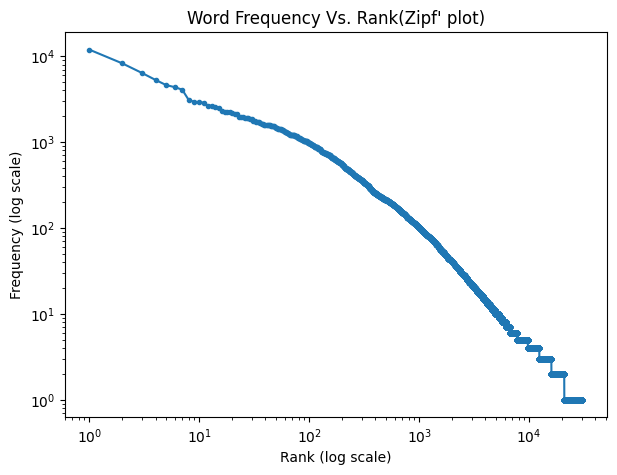

In [33]:
plt.figure(figsize = (7,5))
plt.loglog(range(1, len(vocab_df) + 1), vocab_df["tf"], marker = ".")
plt.title("Word Frequency Vs. Rank(Zipf' plot)")
plt.xlabel("Rank (log scale)")
plt.ylabel("Frequency (log scale)")
plt.show();

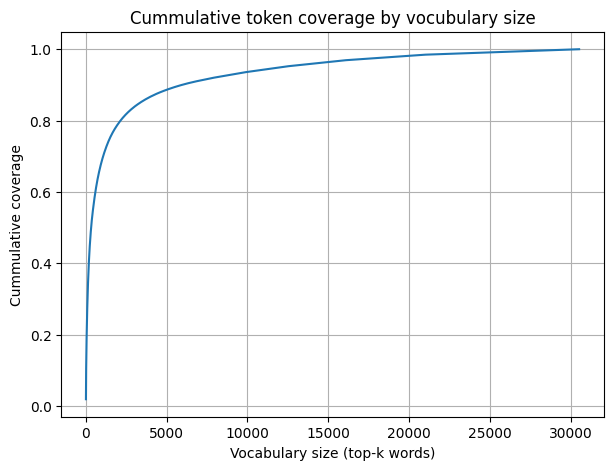

In [34]:
plt.figure(figsize = (7,5))
plt.plot(range(1, len(vocab_df) + 1), vocab_df["cum_coverage"])
plt.title("Cummulative token coverage by vocubulary size")
plt.xlabel("Vocabulary size (top-k words)")
plt.ylabel("Cummulative coverage")
plt.grid(True)
plt.show();

In [35]:
for k in [500, 1000, 5000, 10000, 15000, 20000]:
  coverage = vocab_df.iloc[:k]["cum_coverage"].values[-1]
  print(f"Top {k} tokens cover {coverage*100:.2f}% of total tokens occurance")

Top 500 tokens cover 57.30% of total tokens occurance
Top 1000 tokens cover 68.99% of total tokens occurance
Top 5000 tokens cover 88.64% of total tokens occurance
Top 10000 tokens cover 93.65% of total tokens occurance
Top 15000 tokens cover 96.43% of total tokens occurance
Top 20000 tokens cover 98.18% of total tokens occurance


In [36]:
max_vocab = 10000
tokenizer = Tokenizer(num_words = max_vocab, oov_token = "<OOV>")
tokenizer.fit_on_texts(X_train)
word_idx = tokenizer.word_index
v = len(word_idx)
print(f"Vocabulary size: {v}")
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

Vocabulary size: 30527


In [37]:
MAX_LEN = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen = MAX_LEN, padding = "post", truncating = "post")
X_val_pad   = pad_sequences(X_val_seq,   maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding='post', truncating='post')

In [38]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [39]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

In [40]:
EMB_DIM = 100
input = Input(shape = (MAX_LEN,))
x = Embedding(max_vocab + 1, EMB_DIM, input_length = MAX_LEN)(input)
x = LSTM(150, dropout=0.3, recurrent_dropout=0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)
model = Model(input, x)

In [41]:
learning_rate = 1e-3
optimizer = Adam(learning_rate = learning_rate)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 130)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 130, 100)       │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 150)            │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,160,624 (4.43 MB)

 Trainable params: 1,160,624 (4.43 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
history = model.fit(X_train_pad, y_train_cat, validation_data = (X_val_pad, y_val_cat), epochs = 2)

Epoch 1/2
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 806s 470ms/step - accuracy: 0.3067 - loss: 1.3681 - val_accuracy: 0.3038 - val_loss: 1.3682
Epoch 2/2
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 766s 447ms/step - accuracy: 0.3015 - loss: 1.3692 - val_accuracy: 0.3038 - val_loss: 1.3687


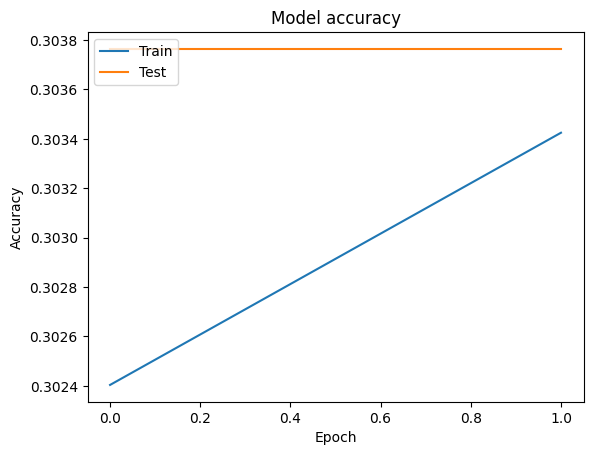

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

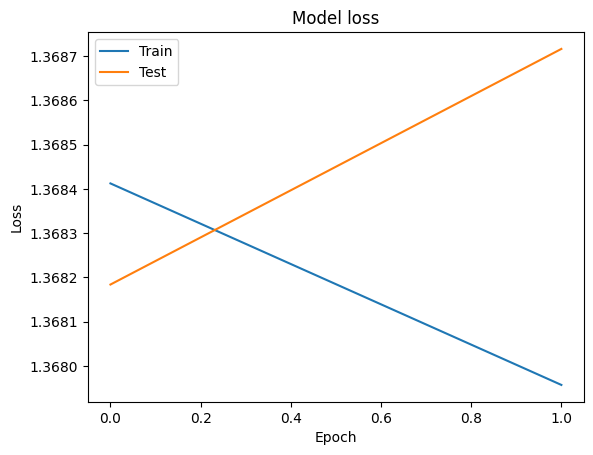

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

In [46]:
loss, accuracy = model.evaluate(X_test_pad, y_test_cat)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

215/215 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.3007 - loss: 1.3677
Test Loss: 1.368611216545105
Test Accuracy: 0.30386579036712646


215/215 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step


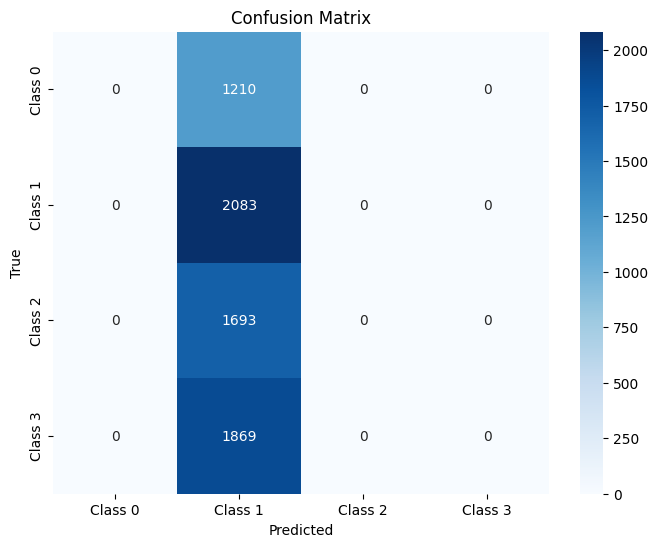

In [47]:
y_pred_probs = model.predict(X_test_pad)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [48]:
input = Input(shape = (MAX_LEN,))
x = Embedding(max_vocab + 1, EMB_DIM, input_length = MAX_LEN)(input)
x = SimpleRNN(150, dropout=0.3, recurrent_dropout=0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)
model = Model(input, x)
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 130)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 130, 100)       │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 150)            │        37,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,047,674 (4.00 MB)

 Trainable params: 1,047,674 (4.00 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history = model.fit(X_train_pad, y_train_cat, epochs=2, validation_data=(X_val_pad, y_val_cat))

Epoch 1/2
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 144s 83ms/step - accuracy: 0.2868 - loss: 1.4147 - val_accuracy: 0.3038 - val_loss: 1.3686
Epoch 2/2
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 142s 83ms/step - accuracy: 0.3020 - loss: 1.3726 - val_accuracy: 0.3038 - val_loss: 1.3680


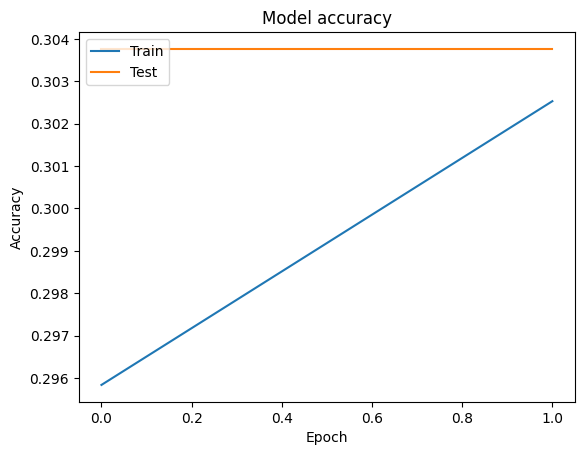

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

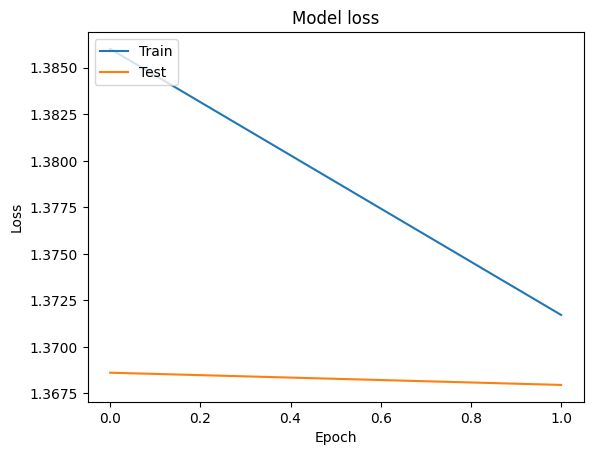

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

In [52]:
loss, accuracy = model.evaluate(X_test_pad, y_test_cat)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3007 - loss: 1.3670
Test Loss: 1.3678702116012573
Test Accuracy: 0.30386579036712646


215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


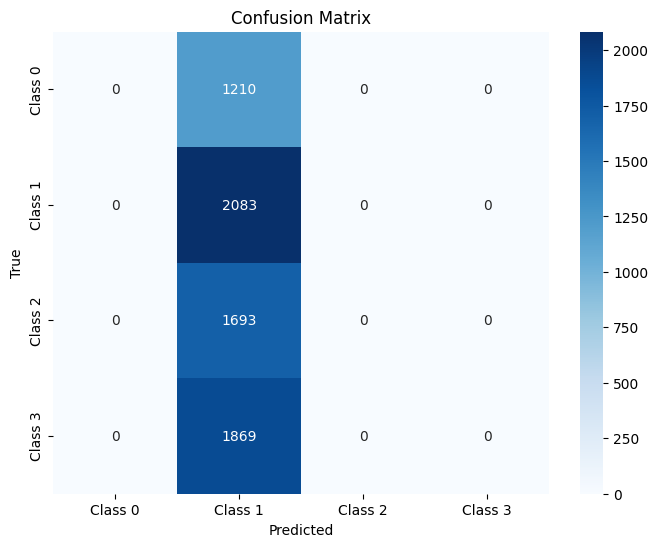

In [53]:
y_pred_probs = model.predict(X_test_pad)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()